In [535]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import StandardScaler
from sklearn.metrics import auc, precision_recall_curve, roc_auc_score, roc_curve, accuracy_score
%matplotlib inline

#ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [536]:
data = pd.read_csv("./train.csv")

data.describe(include="all")

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Braund, Mr. Owen Harris",male,NaN,NaN,NaN,347082,NaN,B96 B98,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


In [537]:
# проверим на недостающие данные
print("train dataset:")
print(pd.isnull(data).sum(), '\n')

train dataset:
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64 



In [538]:
# у 687 из 891 пассажира отстутсвует информация о каюте,
# слишком много пропущенных данных, восстановить будет крайне трудно.
data = data.drop(['Cabin'], axis = 1)

# Информация о номере билета также никак не поможет, т.к. 
# можно считать, что это почти что уникальная величина (681 уникальных значений из 891 значений всего)
data = data.drop(['Ticket'], axis = 1)

# уникальный ID пассажира не влияет на выживаемость по объективным причинам 
data = data.drop(['PassengerId'], axis = 1)

In [539]:
# получим Title (Mr./Mrs./прочее) из имени
data['Title'] = data.Name.str.extract(' ([A-Za-z]+)\.', expand=False)

pd.crosstab(data['Title'], data['Sex'])

# Часть редких или однотипных уважительных обращений можно заменить для лучшей классификации
data['Title'] = data['Title'].replace(['Lady', 'Capt', 'Col',
'Don', 'Dr', 'Major', 'Rev', 'Jonkheer', 'Dona'], 'Rare')

data['Title'] = data['Title'].replace(['Countess', 'Lady', 'Sir'], 'Royal')
data['Title'] = data['Title'].replace('Mlle', 'Miss')
data['Title'] = data['Title'].replace('Ms', 'Miss')
data['Title'] = data['Title'].replace('Mme', 'Mrs')

data[['Title', 'Survived']].groupby(['Title'], as_index=False).mean()

,Title,Survived
0,Master,0.575000
1,Miss,0.702703
2,Mr,0.156673
3,Mrs,0.793651
4,Rare,0.285714
5,Royal,1.000000


In [540]:
# сопоставим каждое значение Title с числовым значением
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Royal": 5, "Rare": 6}
data['Title'] = data['Title'].map(title_mapping)
data['Title'] = data['Title'].fillna(0)
data = data.drop(['Name'], axis = 1)
data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,male,22.0,1,0,7.2500,S,1
1,1,1,female,38.0,1,0,71.2833,C,3
2,1,3,female,26.0,0,0,7.9250,S,2
3,1,1,female,35.0,1,0,53.1000,S,3
4,0,3,male,35.0,0,0,8.0500,S,1


In [541]:
data[data['Fare'].isnull()]

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title


In [542]:
med_fare = data.groupby(['Pclass', 'Parch', 'SibSp']).Fare.median()[3][0][0]
# В Fare пропущено только 1 значение
# Восстановим его на основе медианного значения для группы, в которой находится этот пассажир - одиноких пассажиров третьего класса
data['Fare'] = data['Fare'].fillna(med_fare)

In [543]:
# Посмотрим какой путь отправления был самым популярным
print("Number of people embarking in Southampton (S):")
southampton = data[data["Embarked"] == "S"].shape[0]
print(southampton)

print("Number of people embarking in Cherbourg (C):")
cherbourg = data[data["Embarked"] == "C"].shape[0]
print(cherbourg)

print("Number of people embarking in Queenstown (Q):")
queenstown = data[data["Embarked"] == "Q"].shape[0]
print(queenstown)

Number of people embarking in Southampton (S):
644
Number of people embarking in Cherbourg (C):
168
Number of people embarking in Queenstown (Q):
77


In [544]:
# Так как большинство людей отправлялось именно из Southampton, 
# можно предположить, что 2 недостающие значения также можно заместить именно им.
data['Embarked'] = data['Embarked'].fillna('S')
data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,male,22.0,1,0,7.2500,S,1
1,1,1,female,38.0,1,0,71.2833,C,3
2,1,3,female,26.0,0,0,7.9250,S,2
3,1,1,female,35.0,1,0,53.1000,S,3
4,0,3,male,35.0,0,0,8.0500,S,1


In [545]:
# Попробуем восстановить возраст по двум параметрам - пол и классу пассажирского билета
grouped = data.groupby(['Sex', 'Pclass'])['Age'].transform('median')
data['Age'].fillna(grouped, inplace=True)

In [546]:
data = pd.get_dummies(data, columns=['Sex', 'Embarked', "Pclass"], dtype='int')
data.head()

,Survived,Age,SibSp,Parch,Fare,Title,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3
0,0,22.0,1,0,7.2500,1,0,1,0,0,1,0,0,1
1,1,38.0,1,0,71.2833,3,1,0,1,0,0,1,0,0
2,1,26.0,0,0,7.9250,2,1,0,0,0,1,0,0,1
3,1,35.0,1,0,53.1000,3,1,0,0,0,1,1,0,0
4,0,35.0,0,0,8.0500,1,0,1,0,0,1,0,0,1


In [547]:
y = data["Survived"]
X = data.drop(['Survived'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
X_scaler = StandardScaler()
X_train = X_scaler.fit_transform(X_train)
X_test = X_scaler.transform(X_test)
y_train= y_train.values.reshape(-1,1)
y_test= y_test.values.reshape(-1,1)

In [548]:
lr_model = LogisticRegression(random_state=42)
lr_model.fit(X_train, y_train)

# Вычислим точность
y_pred_lr = lr_model.predict(X_test)
accuracy_lr = round(accuracy_score(y_pred_lr, y_test) * 100, 2)
print(f"Accuracy: {accuracy_lr}")

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def grad_log_loss(X, y, w):
    p = sigmoid(np.dot(X, w))
    m = X.shape[0]
    grad = (1 / m) * np.dot(X.T, (p - y))
    return grad

print("weights:", lr_model.coef_[0], '\n')

print("grad:", grad_log_loss(X_train,y_train,lr_model.coef_[0]))

Accuracy: 80.45
weights: [-0.45480738 -0.44556113 -0.18873483  0.20224496  0.4738834   0.55518063
 -0.55518063  0.10476143 -0.01537394 -0.08114482  0.38750674  0.11243479
 -0.42047738] 

grad: [[ 0.02215527  0.02215527  0.02215527 ...  0.02215527  0.02215527
   0.02215527]
 [ 0.02306226  0.02306226  0.02306226 ...  0.02306226  0.02306226
   0.02306226]
 [-0.0379404  -0.0379404  -0.0379404  ... -0.0379404  -0.0379404
  -0.0379404 ]
 ...
 [-0.12584607 -0.12584607 -0.12584607 ... -0.12584607 -0.12584607
  -0.12584607]
 [-0.05553285 -0.05553285 -0.05553285 ... -0.05553285 -0.05553285
  -0.05553285]
 [ 0.15221185  0.15221185  0.15221185 ...  0.15221185  0.15221185
   0.15221185]]


In [549]:
# Вычислим ROC-AUC для linear classifier
roc_auc_sgd = roc_auc_score(y_test, y_pred_lr)

# Вычислим precision and recall для linear classifier
precision_sgd, recall_sgd, _ = precision_recall_curve(y_test, y_pred_lr)

# Вычислим PR-AUC для linear classifier
pr_auc_sgd = auc(recall_sgd, precision_sgd)


# Прогнозирование вероятностей с помощью linear classifier
y_pred_proba_sgd = lr_model.predict_proba(X_test)[:, 1]

# Вычислим FPR and TPR для linear classifier
fpr_sgd, tpr_sgd, _ = roc_curve(y_test, y_pred_proba_sgd)

In [550]:
# Найдем лучшее значение для n_estimators, max_depth
# проверял и на больших значениях, но слишком долго выполняется, а результат тот же
best_n_estimators = 100
best_acc = 0
best_depth = 1
for n_trees in range(3, 150):
    for n_depth in range(1, 4):
        rf = RandomForestClassifier(n_estimators=n_trees, random_state=42)
        rf.fit(X_train, y_train)
        y_pred = rf.predict(X_test)
        acc = round(accuracy_score(y_pred, y_test) * 100, 2)
        if (acc >best_acc):
            best_acc=acc
            best_n_estimators=n_trees
            best_depth=n_depth

print(f"Лучшая точность ({best_acc}) достигается при n_estimators={best_n_estimators}, max_depth={best_depth}")


# Random Forest
rf_classifier = RandomForestClassifier(n_estimators=best_n_estimators, max_depth=None, random_state=42)
rf_classifier.fit(X_train, y_train)
# Прогнозирование вероятностей с помощью random forest classifier
y_pred_rf = rf_classifier.predict(X_test)
accuracy_randomforest = round(accuracy_score(y_pred_rf, y_test) * 100, 2)
print(accuracy_randomforest)


Лучшая точность (84.36) достигается при n_estimators=102, max_depth=1
84.36


#### Для двух моделей, полученных в п.А., построить ROC и PR (precision-recall) кривые. Получить значения площадей под этими кривыми. Какая метрика (ROC-AUC или PR-AUC) является более предпочтительной в данном примере и почему?

In [551]:
# Вычислим ROC-AUC для random forest classifier
roc_auc_rf = roc_auc_score(y_test, y_pred_rf)

# Вычислим precision and recall для random forest classifier
precision_rf, recall_rf, _ = precision_recall_curve(y_test, y_pred_rf)

# Вычислим PR-AUC для random forest classifier
pr_auc_rf = auc(recall_rf, precision_rf)


# Прогнозирование вероятностей с помощью random forest classifier
y_pred_proba_rf = rf_classifier.predict_proba(X_test)[:, 1]
# вычислим FPR and TPR для random forest classifier
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_proba_rf)


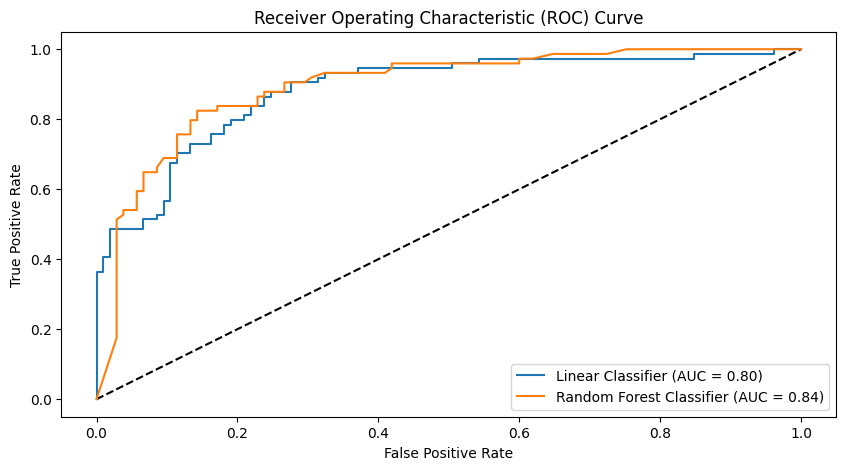

In [552]:
# Plot ROC Curves
plt.figure(figsize=(10, 5))
plt.plot([0, 1], [0, 1], 'k--')

# Linear Classifier ROC Curve
plt.plot(fpr_sgd, tpr_sgd, label='Linear Classifier (AUC = {:.2f})'.format(roc_auc_sgd))

# Random Forest Classifier ROC Curve
plt.plot(fpr_rf, tpr_rf, label='Random Forest Classifier (AUC = {:.2f})'.format(roc_auc_rf))

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

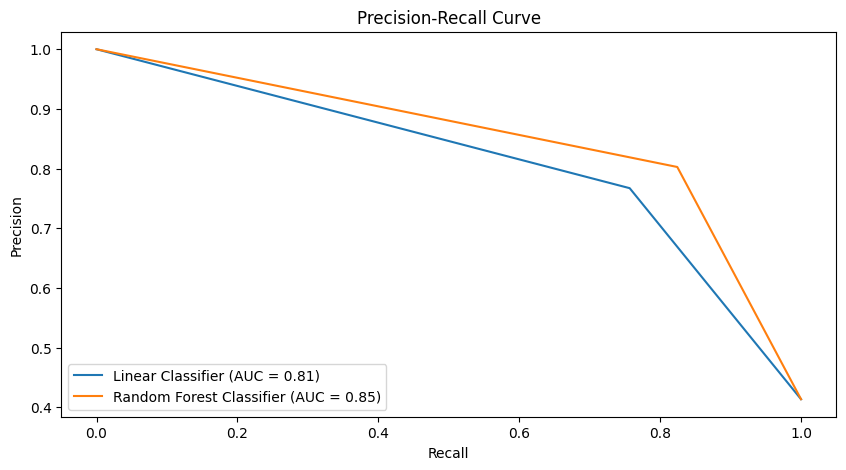

Linear Classifier ROC-AUC: 0.7974259974259975
Random Forest Classifier ROC-AUC: 0.8407335907335909
Linear Classifier PR-AUC: 0.8122193518229334
Random Forest Classifier PR-AUC: 0.8497908007978576


In [553]:
# Plot Precision-Recall Curves
plt.figure(figsize=(10, 5))
plt.plot(recall_sgd, precision_sgd, label='Linear Classifier (AUC = {:.2f})'.format(pr_auc_sgd))

plt.plot(recall_rf, precision_rf, label='Random Forest Classifier (AUC = {:.2f})'.format(pr_auc_rf))

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()

# Print AUC values
print("Linear Classifier ROC-AUC:", roc_auc_sgd)
print("Random Forest Classifier ROC-AUC:", roc_auc_rf)
print("Linear Classifier PR-AUC:", pr_auc_sgd)
print("Random Forest Classifier PR-AUC:", pr_auc_rf)

Как видно по графикам, Random Forest Classifier AUC > Linear Classifier AUC для кривой ROC, следовательно, Random Forest выполняет классификацию более качественно, хоть и не намного.

В данном случае метрика PR-AUC нас интересует больше. Так как задача основана на данных Титаника, мы пытаемся исследовать вопрос "какие люди имели больше шансов выжить?" - следовательно, речь идет о человеческих жизнях и предсказании того, выжил ли человек, то нам важнее получить истинноположительный (TP) результат, чем ложноотрицательный (FN).

# Задача двухклассовой классификации (пункт Б.1)
Рассмотреть простейшую задачу двухклассовой классификации, в которой
элементы выборки имеют нормальное распределение с дисперсией 1 и
средними значениями +𝝁 для экземпляров одного класса и -𝝁 для экземпляров
другого класса. Экземпляры каждого класса появляются в обучающей выборке
с вероятностью ½. Для данной задачи необходимо определить оптимальный
классификатор, а также построить ROC-кривую для различных значений 𝝁



Сгенерируем синтетическую выборку и построим ROC кривую для каждой из средних значений

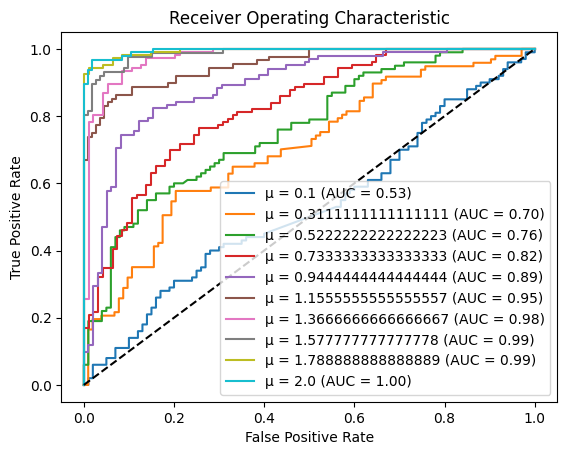

In [554]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.svm import SVC


# Определим набор средних значений (µ), для которых будем строить ROC кривые
mean_values = np.linspace(0.1, 2.0, num=10)

n_samples = 1000

# Оценим классификатор для разных значений µ
roc_auc_values = []
for mean_value in mean_values:
    # Подготовка набора данных для конкретного значения µ
    X = np.concatenate((np.random.normal(mean_value, 1, size=(n_samples // 2)),
                        np.random.normal(-mean_value, 1, size=(n_samples // 2))))
    y = np.concatenate((np.ones(n_samples // 2), np.zeros(n_samples // 2)))
    shuffle_indices = np.random.permutation(n_samples)
    X = X[shuffle_indices]
    y = y[shuffle_indices]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    # для того, чтобы получить графики других классификаторов SVC здесь менялось на другие соответствующие классификаторы
    classifier = SVC(kernel='linear', probability=True, random_state=42)
    classifier.fit(X_train.reshape(-1, 1), y_train)
    y_pred_proba = classifier.predict_proba(X_test.reshape(-1, 1))[:, 1]

    # Получим FPR и TPR для вычисления AUC
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    roc_auc_values.append(roc_auc)

    # Добавляем кривую на график
    plt.plot(fpr, tpr, label=f"µ = {mean_value} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

Поменяем классификатор в коде выше, чтобы построить ROC-кривые для всех классификаторов, сравним получившиеся результаты


RandomForestClassifier:

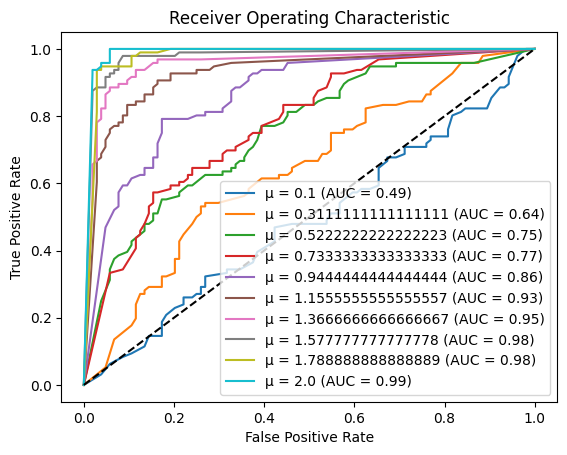

Logistic Regression: 

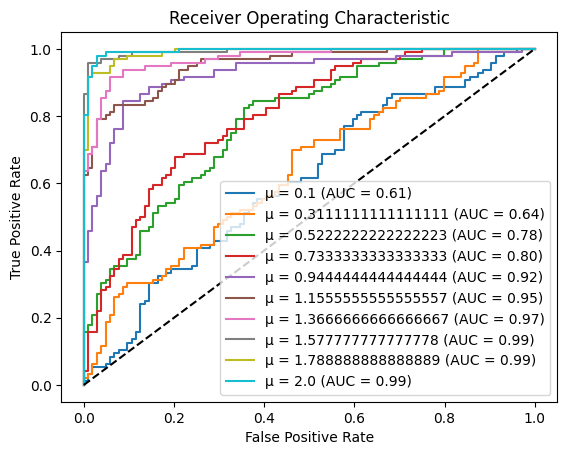


DecisionTreeClassifier: 

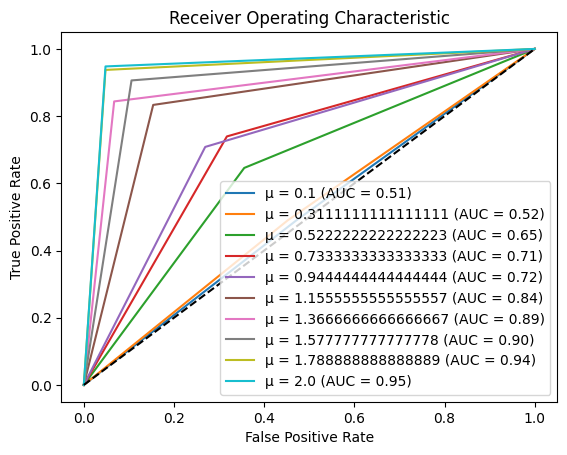


SGDClassifier(loss='log_loss')

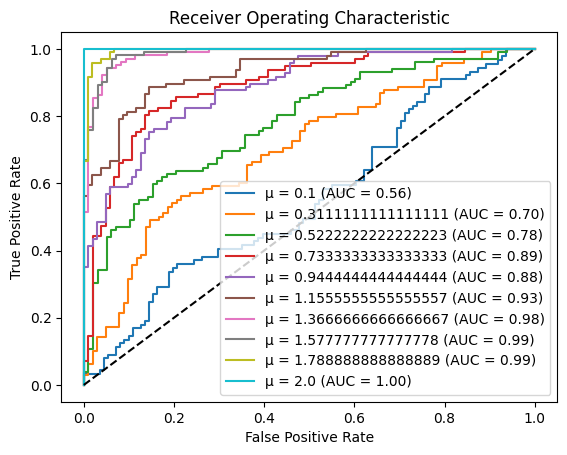


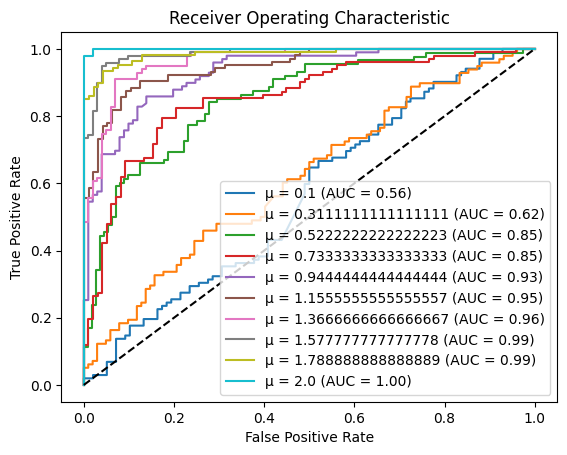

Как видно по графикам, лучшую точность для одних и тех же значений μ в среднем показывает SVM.